### Setttings and modules

In [1]:
import os
import itertools

import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from scipy import stats
from scipy import optimize
import sympy

In [2]:
# matplotlib settings
fit_style = dict(linestyle="-", color="darkgreen", linewidth=1)
marker_style = dict(linestyle="", marker="o", markersize=7, markerfacecolor="mediumblue",
                    markeredgewidth=1, markeredgecolor="firebrick")
error_style = dict(ecolor="red", elinewidth=2, capsize=5)

font_style = {'family' : 'Arial',
              'weight' : 'normal',
              'size'   : 15}
matplotlib.rc("font", **font_style)

In [5]:
# path to data
path_data = "../data/"
path_thickness_variation = path_data + "measurements/"

In [9]:
def get_chi_squared(exp, obs, error, fit_params):
    dof = exp.size - fit_params
    chi_sq = np.sum(((obs - exp) / error) ** 2) / dof
    return chi_sq, (1 - stats.chi2.cdf(chi_sq, dof))

### Energy fit

In [ ]:
[y, x, stdev] = np.loadtxt(path_data + "values_energy_cal.txt", dtype=float).T

result = stats.linregress(x,y)
energy = lambda x: result.slope * x + result.intercept
m = result.slope
b = result.intercept
r_2 = result.rvalue
chi_2, p_val = stats.chisquare(y, f_exp=energy(x), ddof=1)
m_err = result.stderr
b_err = result.intercept_stderr

In [ ]:
E_iron = 14.4
E_err  = 0.1
channel = (E_iron - b) / m
channel_err = np.sqrt(((E_iron - b) * m_err/ m ** 2) ** 2 + (b_err / m) ** 2)
print(f"We estimate E(x)=m*x+b where\nm=({m:.4F}+-{m_err:.4F})keV\tb=({b:.4F}+-{b_err:.4F})keV")
print(f"Iron57-Peak (14.4keV) at channel {channel}+-{channel_err:.3F}\n")
print(f"Correlation coefficient: R^2  = {r_2:.4F}")
print(f"Chi-Squared value: Chi^2={chi_2:.4F} with p={p_val:.4F}")

plt.figure(figsize=(10,7))

plt.errorbar(channel, E_iron, xerr=channel_err,
             linestyle="", marker="d", markersize=9, markerfacecolor="lightgreen",
             markeredgewidth=1,**error_style, label="Energy peak $^{57}$Fe ")
plt.errorbar(x, y, xerr=stdev,
            **marker_style, **error_style, label=f"Straight line fit $E_{{Fit}}(x)$")
plt.plot(np.linspace(0,550), energy(np.linspace(0,550)),
         **fit_style, label="Observed energies $E_{Obs}(x)$")

plt.xlabel("Channel x")
plt.xlim(0,550)
plt.ylabel("Energy E(x) (keV)")
plt.ylim(0,35)

plt.legend(fancybox=True, loc="upper left")
plt.grid()
plt.savefig('energy_fit.pdf', pad_inches=0.1, bbox_inches="tight")
plt.show()

### FePO_4

In [ ]:
# constants
c = 3e11 # mm/s
e = 0.30282212088 
e0= 14.413e3 # eV
bohr_mag = 98.3585815e-8 # 1/eV
muG = 0.090604 * bohr_mag # 1 / eV
Q = 539 * 10 ** (-18) # 1 / eV^2
iG = 1/2
iA = 3/2
# define relevant equations 
def energy_eq(v, mG, mA, qSign, muA, B, Vzz, Is):
    return (muG * (mG / iG ) - muA * (mA / iA)) * B + qSign * e * Q * Vzz / 4 + Is - e0 * v / c

In [ ]:
# define system of equations
# parameters
# positive velocity -> lower energy
vs     =          [-1.6392 , -5.1666  , -8.4986  , 8.1787   , 4.4098   , 0.96819 ] # mm/s
v_errs = np.array([0.013254, 0.0066389, 0.0037914, 0.0040645, 0.0078983, 0.014312])
mGs    =          [1/2     , 1/2      , 1/2       , -1/2    , -1/2     , -1/2    ]
mAs    =          [-1/2    , 1/2      , 3/2       , -3/2    , -1/2     , 1/2     ]
qSigns =          [1, 1, -1, -1, 1, 1]
parameters = np.array([vs, mGs, mAs, qSigns]).T
# variables
vars = sympy.symbols('muA, B, Vzz, Is')
# system
system = [energy_eq(*param_set, *vars) for param_set in parameters]
# solve system for all combinations
combinations = list(itertools.combinations(range(6), 4))
subsystems = [[system[i] for i in combi] for combi in combinations]
results = []
for sys, combi in zip(subsystems, combinations):
    solution = sympy.nonlinsolve(sys, vars)
    results.append(list(*solution))

# print results
print("Eq.   \t | \tmuA [1/eV] \t |   B [eV^2] \t |   Vzz [eV^2]\t |\t Is [eV]")
for combi, sol in zip(combinations, results):
    if len(sol) == 0:
        print(f"{combi}:\tNo solution!")
    else:
        print(f"{combi}:\t {sol[0]:.3E} \t | {sol[1]:.3E} \t | {sol[2]:.3E} \t | {sol[3]:.3E} \t")

In [ ]:
# results in actual units
sol = np.array([r for r in results if r], dtype=float).T

# yeah this is kinda cheaty but wth (dont do this)
rel_v_err = 1 + np.abs(e0 * np.linalg.norm(v_errs) / (2 * c * np.mean(sol[3])))

muA = np.mean(sol[0]) / bohr_mag
muA_err = np.std(sol[0]) * rel_v_err / bohr_mag
print(f"muA = ({muA:.4f}+-{muA_err:.4f}) mu_Bohr")
B = np.mean(sol[1]) * (1.5 * bohr_mag) / 4.8077e-8
B_err = np.std(sol[1]) * (1.5 * bohr_mag) * rel_v_err / 4.8077e-8
print(f"B = ({B:.4f}+-{B_err:.4f}) T")
Vzz = np.mean(sol[2]) * 1e-9
Vzz_err = np.std(sol[2]) * 1e-9 * rel_v_err
print(f"Vzz = ({Vzz:.4f}+-{Vzz_err:.4f}) keV^3")
Is = np.mean(sol[3]) * 1e9
Is_err = np.std(sol[3]) * 1e9 * rel_v_err
print(f"Is = ({Is:.4f}+-{Is_err:.4f}) neV")

### Thickness variation

In [6]:
file_names = os.listdir(path_thickness_variation)
ampl = np.zeros(len(file_names))
ampl_error = np.zeros(len(file_names))

for i, file in enumerate(file_names):
    counts = np.loadtxt(path_thickness_variation + file, skiprows=1, comments="<", dtype=int)
    zInf = np.average(counts[:counts.size//4])
    z0 = np.average(np.sort(counts)[:3])
    zInf_error = np.std(counts[:counts.size//4])
    z0_error = np.std(np.sort(counts)[:3])
    ampl[i] = (zInf - z0) / zInf
    ampl_error[i] = np.sqrt((z0_error / zInf) ** 2 + (z0 * zInf_error / (zInf ** 2)) ** 2)

f_a = 0.2009854486679279 +- 0.0032829136233326144
f_s = 0.6735579390732193 +- 0.006015187881027175
chi^2 = 2.4881930619312578 , p-val = 0.6467512489077687


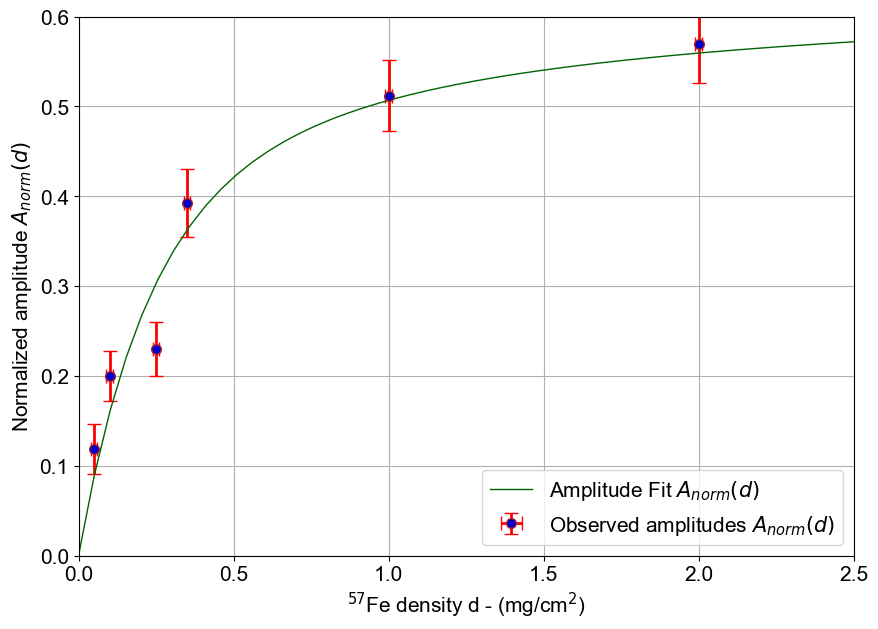

In [10]:
def amplitude(d, fS, fA):
    T = 0.606 * fA * d / 0.021
    return fS * (1 - np.exp(- T / 2) * np.i0(T / 2))

[d, gamma, gamma_err] = np.loadtxt(path_data + "dicke.txt").T
[fS, fA], cov = optimize.curve_fit(amplitude, d, ampl, sigma=ampl_error)

print("f_a =", fA, "+-", cov[1,1])
print("f_s =", fS, "+-", cov[0,0])
chi_2, p_val = get_chi_squared(amplitude(d, fS, fA), ampl, ampl_error, 2)
print("chi^2 =", chi_2, ", p-val =", p_val)

plt.figure(figsize=(10,7))
# we assume the density error to be +-0.01 mg/cm^2
d_error = np.full((6),0.01)
plt.errorbar(d, ampl, xerr=d_error, yerr=ampl_error,
             **marker_style, **error_style, label="Observed amplitudes $A_{norm}(d)$")
plt.plot(np.linspace(0,2.5), amplitude(np.linspace(0,2.5), fS, fA),
         **fit_style, label="Amplitude Fit $A_{norm}(d)$")

plt.xlabel("$^{57}$Fe density d - (mg/cm$^2$)")
plt.xlim(0, 2.5)
plt.ylabel("Normalized amplitude $A_{norm}(d)$")
plt.ylim(0, 0.6)

plt.legend(fancybox=True,loc="lower right")
plt.grid()
plt.savefig('thickness_variation_amplitude.pdf', pad_inches=0.1, bbox_inches="tight")
plt.show()

<>:16: SyntaxWarning: invalid escape sequence '\G'
<>:18: SyntaxWarning: invalid escape sequence '\G'
<>:22: SyntaxWarning: invalid escape sequence '\G'
<>:16: SyntaxWarning: invalid escape sequence '\G'
<>:18: SyntaxWarning: invalid escape sequence '\G'
<>:22: SyntaxWarning: invalid escape sequence '\G'
C:\Users\LInus\AppData\Local\Temp\ipykernel_1488\1212920149.py:16: SyntaxWarning: invalid escape sequence '\G'
  **marker_style, **error_style, label="Linewidths $\Gamma_{m}(d, f_A)$")
C:\Users\LInus\AppData\Local\Temp\ipykernel_1488\1212920149.py:18: SyntaxWarning: invalid escape sequence '\G'
  **fit_style, label="Linewidth Fit for $\Gamma_{m}(d)$")
C:\Users\LInus\AppData\Local\Temp\ipykernel_1488\1212920149.py:22: SyntaxWarning: invalid escape sequence '\G'
  plt.ylabel("Observed linewidth $\Gamma_{m}(d)$ (mm/s)")


Gamma0 =  3.024043300715482e-09 +- 1.4423099905525296e-14
fA =  1.858359197221516 +- 0.0008534158676962846
chi^2 = 0.0013336428784412578 , p-val = 0.970868468770659
T values:  [  2.68134684   5.36269368  13.40673421  18.76942789  53.62693683
 107.25387367]


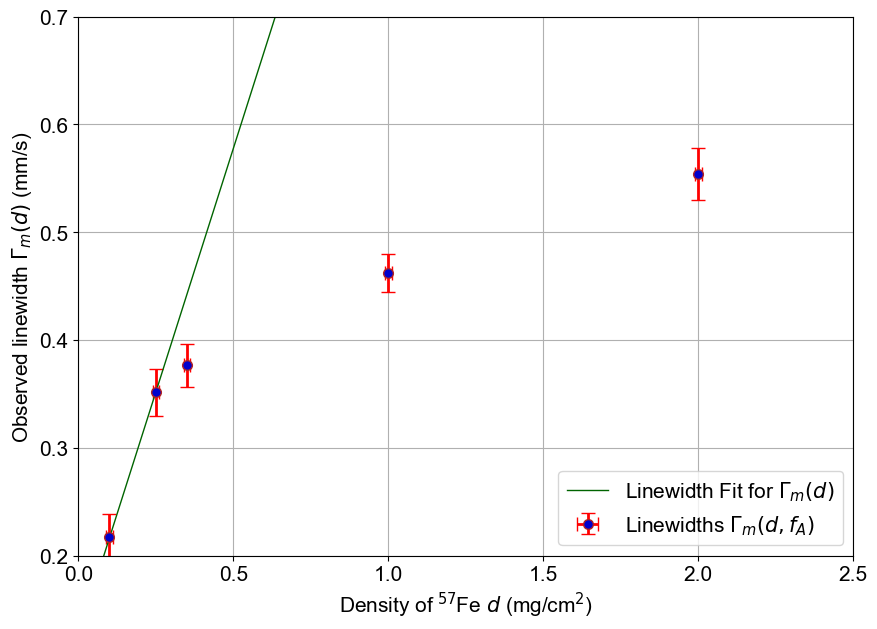

In [11]:
def gamma_gem(d, gamma0, fA):
    T = 0.606 * fA * d / 0.021
    return 2 * gamma0 * ( 1 + 0.134 * T)

end = -3
[gamma0, fA], cov = optimize.curve_fit(gamma_gem, d[:end], gamma[:end])
print("Gamma0 = ", gamma0 * 4.8077e-8, "+-", cov[0,0] * 4.8077e-8)
print("fA = ", fA, "+-", cov[1,1])
chi_2, p_val = get_chi_squared(gamma_gem(d[:end], gamma0, fA), gamma[:end], ampl_error[:end], 2)
print("chi^2 =", chi_2, ", p-val =", p_val)
print("T values: ", 0.606 * fA * d / 0.021)
plt.figure(figsize=(10,7))
# we assume the density error to be +-0.01 mg/cm^2
d_error = np.full((6),0.01)
plt.errorbar(d, gamma, xerr=d_error, yerr=gamma_err,
             **marker_style, **error_style, label="Linewidths $\Gamma_{m}(d, f_A)$")
plt.plot(np.linspace(0,2.5), gamma_gem(np.linspace(0,2.5), gamma0, fA),
         **fit_style, label="Linewidth Fit for $\Gamma_{m}(d)$")

plt.xlabel("Density of $^{57}$Fe $d$ (mg/cm$^2$)")
plt.xlim(0, 2.5)
plt.ylabel("Observed linewidth $\Gamma_{m}(d)$ (mm/s)")
plt.ylim(0.2, 0.7)

plt.legend(fancybox=True,loc="lower right")
plt.grid()
plt.savefig('thickness_variation_linfit.pdf', pad_inches=0.1, bbox_inches="tight")
plt.show()